In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm 
import open3d as o3d
import numpy as np
import cv2
import os
import sys

## Pipeline SfM:

- Detekcja cech
  - SIFT
  - SURF
  - ORB
- Dopasowanie cech między klatkami
  - FLANN (cv2.FlannBasedMatcher)
- Filtracja punktów
- Estymacja położenia kamer
- Triangulacja
- visualize


In [2]:
def extract_frames(video_path, frame_interval=30, max_frames=100):
    """
    Extract frames from a video file.

    Parameters:
        video_path (str): Path to the video file.
        frame_interval (int): Extract one frame every 'frame_interval' frames.
        max_frames (int): Maximum number of frames to extract.

    Returns:
        List of extracted frames as BGR images.
    """
    if not os.path.isfile(video_path):
        print(f"Video file not found: {video_path}")
        sys.exit(1)
    
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    extracted = 0
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    expected_frames = min(max_frames, total_frames // frame_interval)
    
    with tqdm(total=expected_frames, desc="Extracting frames") as pbar:
        while cap.isOpened() and extracted < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_interval == 0:
                frames.append(frame)
                extracted += 1
                pbar.update(1)
            count += 1
    
    cap.release()
    print(f"Total extracted frames: {len(frames)}")
    return frames

In [3]:
def detect_and_compute_features(images):
    """
    Detect SIFT features and compute descriptors with better parameters.
    """
    # Create SIFT with more selective parameters
    sift = cv2.SIFT_create(
        nfeatures=2000,          # More features for better coverage
        nOctaveLayers=3,         # Default value
        contrastThreshold=0.04,  # Increased to get stronger features
        edgeThreshold=10,        # Default value
        sigma=1.6                # Default value
    )
    
    keypoints_list = []
    descriptors_list = []
    num_keypoints = 0
    
    # Convert images to list if it's a generator or other iterable
    images_list = list(images)
    
    for idx, img in tqdm(enumerate(images_list), total=len(images_list), desc="Detecting features"):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Add Gaussian blur to reduce noise
        gray = cv2.GaussianBlur(gray, (0, 0), 1.0)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)
        num_keypoints += len(keypoints)
    
    return keypoints_list, descriptors_list

In [4]:
def match_features(des1, des2, ratio=0.6):  # Stricter ratio test
    """
    Match features with stricter filtering.
    """
    if des1 is None or des2 is None:
        return []
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=100)  # More checks for better accuracy
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    try:
        matches = flann.knnMatch(des1, des2, k=2)
    except cv2.error as e:
        print("Error during FLANN matching:", e)
        return []
    
    # Stricter ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance and m.distance < 200:  # Added absolute distance threshold
            good_matches.append(m)
    
    return good_matches

In [5]:
def visualize_matches(img1, kp1, img2, kp2, matches, max_matches=50):
    """
    Visualize matches between two images.

    Parameters:
        img1: First image (BGR).
        kp1: Keypoints from the first image.
        img2: Second image (BGR).
        kp2: Keypoints from the second image.
        matches: List of matches.
        max_matches: Maximum number of matches to display.
    """
    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:max_matches], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Top {max_matches} Matches")
    plt.axis('off')
    plt.show()

In [6]:
def extract_frames_from_directory(directory_path, max_frames=100):
    """
    Extract frames from a directory of images.
    """
    frames = []
    for file in os.listdir(directory_path):
        if file.endswith(".JPG") or file.endswith(".png"):
            img = cv2.imread(os.path.join(directory_path, file))
            frames.append(img)
    return frames

In [7]:
# # Path to your video file
video_path = 'dane6/rollei3.mov'  # Replace with your video path

# # Parameters
frame_interval = 2   # Extract one frame every x frames
max_frames = 300    # Maximum number of frames to extract

# # Extract frames
# frames = extract_frames(video_path, frame_interval, max_frames)


directory_path = 'dane6/south-building/images'
# instead of video, get frames from directory
frames = extract_frames_from_directory(directory_path, max_frames)

In [8]:
keypoints_list, descriptors_list = detect_and_compute_features(frames)

Detecting features: 100%|██████████| 128/128 [01:08<00:00,  1.86it/s]


Number of good matches between Frame 1 and Frame 2: 682


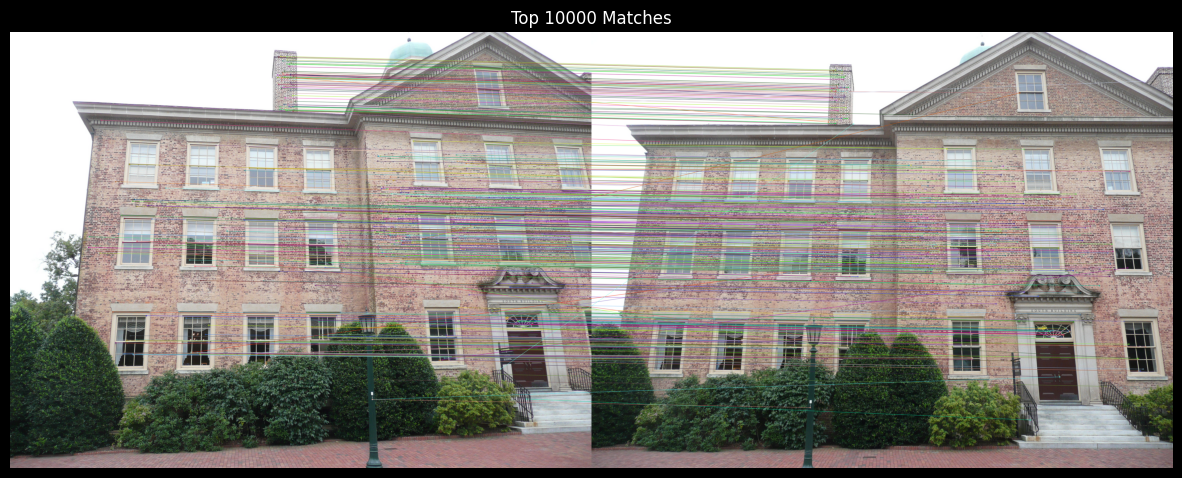

In [9]:
# Ensure we have at least two frames
if len(frames) < 2:
    print("Need at least two frames for reconstruction.")
    sys.exit(1)

# Select the first two frames
img1 = frames[0]
img2 = frames[1]
kp1  = keypoints_list[0]
kp2  = keypoints_list[1]
des1 = descriptors_list[0]
des2 = descriptors_list[1] 

# Match features
good_matches = match_features(des1, des2, ratio=0.8)
print(f"Number of good matches between Frame 1 and Frame 2: {len(good_matches)}")

# Optional: Visualize matches
visualize_matches(img1, kp1, img2, kp2, good_matches, max_matches=10000)

In [10]:
def estimate_pose_and_triangulate(kp1, kp2, matches, K, debug=False):
    """
    Estimate camera pose and triangulate 3D points.
    """
    if len(matches) < 8:
        print("Not enough matches to compute Essential matrix.")
        return None, None, None, None

    # Extract matched keypoints
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    if debug:   
        print(f"Number of matches before RANSAC: {len(matches)}")

    # Compute Essential matrix with more relaxed threshold
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, 
                                  prob=0.999, threshold=3.0)  # Increased threshold
    if debug:
        print(f"Number of matches after RANSAC: {len(matches)}")
    if E is None:
        if debug:
            print("Essential matrix estimation failed.")
        return None, None, None, None

    # Recover pose
    points_in_front, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)
    
    if debug:
        print(f"Number of points in front of camera: {points_in_front}")
        print("Recovered Pose:")
        print("Rotation Matrix R:")
        print(R)
        print("Translation Vector t:")
        print(t)

    # Triangulate points
    P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
    P2 = K @ np.hstack((R, t))

    # Convert points to homogeneous coordinates
    pts1_h = cv2.convertPointsToHomogeneous(pts1)[:, 0, :]
    pts2_h = cv2.convertPointsToHomogeneous(pts2)[:, 0, :]

    # Triangulate all points
    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    points_3d = (points_4d / points_4d[3]).T[:, :3]

    # Filter points based on positive depth and reprojection error
    depths1 = points_3d[:, 2]
    depths2 = (R @ points_3d.T + t).T[:, 2]
    
    # Keep points with positive depth in both views
    mask_depths = (depths1 > 0) & (depths2 > 0)
    points_3d = points_3d[mask_depths]
    
    # Center the points around origin
    centroid = np.mean(points_3d, axis=0)
    points_3d = points_3d - centroid
    
    # Scale the points to a reasonable size
    scale = 10.0 / np.max(np.abs(points_3d))
    points_3d = points_3d * scale
    t = t * scale  # Scale translation vector accordingly
    
    if debug:
        if len(points_3d) < 10:
            print(f"Too few valid 3D points: {len(points_3d)}")
            return None, None, None, None

        print(f"Number of valid 3D points: {len(points_3d)}")
    return R, t, points_3d, mask_pose

In [11]:
# Example intrinsic parameters based on FOV and image resolution
f_x = 3225.6
f_y = 3225.6
c_x = img1.shape[1] / 2  # 4032 / 2 = 2016
c_y = img1.shape[0] / 2  # 3024 / 2 = 1512

K = np.array([[f_x, 0, c_x],
              [0, f_y, c_y],
              [0,  0,    1]])
print("Updated Camera Intrinsic Matrix K:")
print(K)

Updated Camera Intrinsic Matrix K:
[[3.2256e+03 0.0000e+00 1.5360e+03]
 [0.0000e+00 3.2256e+03 1.1520e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00]]


In [12]:
R, t, points_3d, mask = estimate_pose_and_triangulate(kp1, kp2, good_matches, K)

if R is None or t is None or points_3d is None:
    print("Pose estimation or triangulation failed. Try adjusting parameters or using different frames.")

In [13]:
def filter_points(points_3d, percentile=95):
    """
    Filter out outlier points based on distance from median.
    """
    # Calculate distances from median point
    median = np.median(points_3d, axis=0)
    distances = np.linalg.norm(points_3d - median, axis=1)
    
    # Filter out points beyond the specified percentile
    threshold = np.percentile(distances, percentile)
    mask = distances < threshold
    
    return points_3d[mask]

def visualize_3d_reconstruction(points_3d, R, t, K):
    """
    Visualize 3D points and camera poses using Open3D with improved visualization.
    """
    # Filter outlier points
    filtered_points = filter_points(points_3d, percentile=98)
    # filtered_points = points_3d
    # Create Open3D point cloud
    o3d_cloud = o3d.geometry.PointCloud()
    o3d_cloud.points = o3d.utility.Vector3dVector(filtered_points)
    
    # Add colors based on height (z-coordinate)
    colors = np.zeros((len(filtered_points), 3))
    z_vals = filtered_points[:, 2]
    z_min, z_max = np.min(z_vals), np.max(z_vals)
    normalized_z = (z_vals - z_min) / (z_max - z_min)
    
    # Create a color gradient (blue to red)
    colors[:, 0] = normalized_z  # Red channel
    colors[:, 2] = 1 - normalized_z  # Blue channel
    o3d_cloud.colors = o3d.utility.Vector3dVector(colors)
    
    # Statistical outlier removal
    # o3d_cloud, _ = o3d_cloud.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    
    # Create a visualization window
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=2560, height=1440)
    
    # Add geometries
    vis.add_geometry(o3d_cloud)
    
    # Set rendering options
    opt = vis.get_render_option()
    opt.point_size = 3.0  # Increased point size
    opt.background_color = np.asarray([0.1, 0.1, 0.1])  # Dark gray background
    
    # Set camera viewpoint
    ctr = vis.get_view_control()
    ctr.set_zoom(0.7)
    ctr.set_front([-0.5, -0.5, -0.5])
    ctr.set_lookat([0, 0, 0])
    ctr.set_up([0, -1, 0])
    
    # Run visualization
    vis.run()
    vis.destroy_window()

In [14]:
len(points_3d)

657

In [15]:
# visualization from only 2 images
visualize_3d_reconstruction(points_3d, R, t, K) 

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


2024-12-19 17:55:56.556 python[77146:4567452] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-19 17:55:56.556 python[77146:4567452] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [16]:
def estimate_pose_and_triangulate(kp1, kp2, matches, K, debug=False):
    """
    Estimate camera pose and triangulate 3D points with improved error handling.
    """
    if len(matches) < 8:
        if debug:
            print("Not enough matches to compute Essential matrix.")
        return None, None, None, None

    # Extract matched keypoints
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Compute Essential matrix
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, 
                                  prob=0.999, threshold=3.0)
    
    if E is None:
        if debug:
            print("Essential matrix estimation failed.")
        return None, None, None, None

    # Recover pose
    points_in_front, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)
    
    if points_in_front < 10:  # Add minimum points threshold
        if debug:
            print(f"Too few points in front of camera: {points_in_front}")
        return None, None, None, None

    # Triangulate points
    P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
    P2 = K @ np.hstack((R, t))

    pts1_h = cv2.convertPointsToHomogeneous(pts1)[:, 0, :]
    pts2_h = cv2.convertPointsToHomogeneous(pts2)[:, 0, :]

    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    points_3d = (points_4d / points_4d[3]).T[:, :3]

    # Filter points based on positive depth
    depths1 = points_3d[:, 2]
    depths2 = (R @ points_3d.T + t).T[:, 2]
    mask_depths = (depths1 > 0) & (depths2 > 0)
    points_3d = points_3d[mask_depths]

    if len(points_3d) < 10:  # Add minimum points threshold
        if debug:
            print(f"Too few valid 3D points after filtering: {len(points_3d)}")
        return None, None, None, None

    # Center and scale points only if we have valid points
    if len(points_3d) > 0:
        centroid = np.mean(points_3d, axis=0)
        points_3d = points_3d - centroid
        
        # Avoid division by zero in scaling
        max_abs_val = np.max(np.abs(points_3d))
        if max_abs_val > 1e-10:  # Add small threshold
            scale = 10.0 / max_abs_val
            points_3d = points_3d * scale
            t = t * scale
        else:
            if debug:
                print("Points too close to origin, skipping scaling")
    
    return R, t, points_3d, mask_pose
def reconstruct_sequence(frames, keypoints_list, descriptors_list, K, max_frame_gap=3):
    """
    Reconstruct 3D scene with adaptive frame selection
    """
    all_points_3d = []
    all_cameras = []
    
    # Initialize first camera at origin
    all_cameras.append((np.eye(3), np.zeros((3, 1))))
    
    i = 0
    while i < len(frames) - 1:
        success = False
        
        # Try different frame gaps if initial matching fails
        for frame_gap in range(1, max_frame_gap + 1):
            if i + frame_gap >= len(frames):
                break
                
            matches = match_features(descriptors_list[i], descriptors_list[i + frame_gap])
            
            if len(matches) >= 50:  # Require more matches for reliability
                print(f"Found {len(matches)} matches between frames {i} and {i + frame_gap}")
                
                R, t, points_3d, mask = estimate_pose_and_triangulate(
                    keypoints_list[i], 
                    keypoints_list[i + frame_gap], 
                    matches, 
                    K,
                    debug=True
                )
                
                if R is not None and t is not None and points_3d is not None and len(points_3d) > 20:
                    # Transform points to global coordinate system
                    if len(all_cameras) > 1:
                        R_prev, t_prev = all_cameras[-1]
                        R_new = R_prev @ R
                        t_new = t_prev + R_prev @ t
                        all_cameras.append((R_new, t_new))
                        points_3d = (R_prev @ points_3d.T + t_prev).T
                    else:
                        all_cameras.append((R, t))
                    
                    all_points_3d.extend(points_3d)
                    success = True
                    i += frame_gap
                    break
        
        if not success:
            print(f"Failed to find good matches after frame {i}, skipping...")
            i += 1
    
    if len(all_points_3d) > 0:
        all_points_3d = np.array(all_points_3d)
        print(f"Final reconstruction has {len(all_points_3d)} points and {len(all_cameras)} cameras")
    else:
        print("Warning: No valid points reconstructed")
        return np.array([]), []
    
    return all_points_3d, all_cameras

def visualize_full_reconstruction(all_points_3d, all_cameras):
    """
    Visualize the complete 3D reconstruction with camera positions.
    """
    # Filter outliers
    filtered_points = filter_points(all_points_3d, percentile=98)
    
    # Create Open3D point cloud
    o3d_cloud = o3d.geometry.PointCloud()
    o3d_cloud.points = o3d.utility.Vector3dVector(filtered_points)
    
    # Add colors based on height
    colors = np.zeros((len(filtered_points), 3))
    z_vals = filtered_points[:, 2]
    z_min, z_max = np.min(z_vals), np.max(z_vals)
    normalized_z = (z_vals - z_min) / (z_max - z_min)
    colors[:, 0] = normalized_z
    colors[:, 2] = 1 - normalized_z
    o3d_cloud.colors = o3d.utility.Vector3dVector(colors)
    
    # Create visualization
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=2560, height=1440)
    vis.add_geometry(o3d_cloud)
    
    # Add camera frustums
    for R, t in all_cameras:
        # Create camera frustum geometry
        cam_size = 0.1
        camera_points = np.array([
            [0, 0, 0],
            [-cam_size, -cam_size, cam_size],
            [cam_size, -cam_size, cam_size],
            [cam_size, cam_size, cam_size],
            [-cam_size, cam_size, cam_size]
        ])
        
        # Transform camera points to global coordinate system
        camera_points = (R @ camera_points.T + t).T
        
        # Create lines for camera frustum
        lines = [[0, 1], [0, 2], [0, 3], [0, 4],
                [1, 2], [2, 3], [3, 4], [4, 1]]
        
        # Create LineSet for camera frustum
        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(camera_points)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in range(len(lines))])
        vis.add_geometry(line_set)
    
    # Set rendering options
    opt = vis.get_render_option()
    opt.point_size = 3.0
    opt.background_color = np.asarray([0.1, 0.1, 0.1])
    
    # Set camera viewpoint
    ctr = vis.get_view_control()
    ctr.set_zoom(0.7)
    ctr.set_front([-0.5, -0.5, -0.5])
    ctr.set_lookat([0, 0, 0])
    ctr.set_up([0, -1, 0])
    
    # Run visualization
    vis.run()
    vis.destroy_window()

In [17]:
all_points_3d, all_cameras = reconstruct_sequence(frames, keypoints_list, descriptors_list, K)

Found 531 matches between frames 0 and 1
Found 253 matches between frames 1 and 3
Found 299 matches between frames 3 and 4
Failed to find good matches after frame 4, skipping...
Failed to find good matches after frame 5, skipping...
Found 329 matches between frames 6 and 9
Found 216 matches between frames 9 and 11
Found 549 matches between frames 11 and 14
Found 106 matches between frames 14 and 15
Failed to find good matches after frame 15, skipping...
Failed to find good matches after frame 16, skipping...
Failed to find good matches after frame 17, skipping...
Found 517 matches between frames 18 and 21
Failed to find good matches after frame 21, skipping...
Failed to find good matches after frame 22, skipping...
Found 307 matches between frames 23 and 25
Failed to find good matches after frame 25, skipping...
Failed to find good matches after frame 26, skipping...
Failed to find good matches after frame 27, skipping...
Failed to find good matches after frame 28, skipping...
Found 16

In [18]:
visualize_full_reconstruction(all_points_3d, all_cameras)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [19]:
a

NameError: name 'a' is not defined

In [31]:
def track_features_across_frames(frames, keypoints_list, descriptors_list):
    """
    Track features across multiple frames and create feature tracks.
    Returns a list of tracks, where each track is a dict containing frame indices and point locations.
    """
    n_frames = len(frames)
    tracks = []
    next_track_id = 0
    active_tracks = {}  # track_id -> (last_frame_idx, keypoint_idx, descriptor)
    
    for i in tqdm(range(n_frames - 1), desc="Tracking features"):
        # Match features with next frame
        matches = match_features(descriptors_list[i], descriptors_list[i+1])
        
        # Update existing tracks and create new ones
        current_tracks = {}
        
        for m in matches:
            query_idx = m.queryIdx
            train_idx = m.trainIdx
            
            # Check if this keypoint belongs to an existing track
            track_found = False
            for track_id, (frame_idx, kp_idx, _) in active_tracks.items():
                if frame_idx == i and kp_idx == query_idx:
                    # Extend existing track
                    tracks[track_id]['frame_ids'].append(i + 1)
                    tracks[track_id]['points'].append(keypoints_list[i+1][train_idx].pt)
                    current_tracks[track_id] = (i + 1, train_idx, descriptors_list[i+1][train_idx])
                    track_found = True
                    break
            
            if not track_found:
                # Create new track
                track = {
                    'track_id': next_track_id,
                    'frame_ids': [i, i + 1],
                    'points': [
                        keypoints_list[i][query_idx].pt,
                        keypoints_list[i+1][train_idx].pt
                    ]
                }
                tracks.append(track)
                current_tracks[next_track_id] = (i + 1, train_idx, descriptors_list[i+1][train_idx])
                next_track_id += 1
        
        active_tracks = current_tracks
    
    # Filter tracks - keep only long tracks
    min_track_length = 3  # Minimum number of frames a track should span
    filtered_tracks = [t for t in tracks if len(t['frame_ids']) >= min_track_length]
    
    print(f"Total tracks: {len(tracks)}")
    print(f"Filtered tracks: {len(filtered_tracks)}")
    
    return filtered_tracks

def reconstruct_from_tracks(frames, K, tracks):
    """
    Perform 3D reconstruction using feature tracks.
    """
    # Initialize camera poses (first camera at origin)
    n_frames = len(frames)
    poses = [np.eye(4) for _ in range(n_frames)]  # Initialize all poses
    
    # Initialize 3D points
    points_3d = []
    point_colors = []
    track_lengths = []
    
    # First, estimate relative poses between consecutive frames
    for i in range(n_frames - 1):
        # Find tracks that include both frames i and i+1
        current_tracks = [t for t in tracks if i in t['frame_ids'] and i+1 in t['frame_ids']]
        
        if len(current_tracks) < 8:
            continue
            
        # Get corresponding points
        idx1 = [t['frame_ids'].index(i) for t in current_tracks]
        idx2 = [t['frame_ids'].index(i+1) for t in current_tracks]
        pts1 = np.float32([t['points'][i1] for t, i1 in zip(current_tracks, idx1)])
        pts2 = np.float32([t['points'][i2] for t, i2 in zip(current_tracks, idx2)])
        
        # Estimate Essential matrix
        E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        if E is None:
            continue
            
        # Recover relative pose
        _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)
        
        # Update pose (compose with previous pose)
        rel_pose = np.eye(4)
        rel_pose[:3, :3] = R
        rel_pose[:3, 3] = t.flatten()
        poses[i+1] = poses[i] @ rel_pose
    
    # Now triangulate points using all available views
    for track in tqdm(tracks, desc="Triangulating points"):
        if len(track['frame_ids']) < 3:
            continue
            
        # Collect all observations for this track
        frame_ids = track['frame_ids']
        points_2d = np.float32([track['points'][i] for i in range(len(frame_ids))])
        
        # Normalize points
        points_2d_norm = np.array([
            cv2.undistortPoints(pt.reshape(1,1,2), K, None).reshape(2)
            for pt in points_2d
        ])
        
        # Triangulate using the first two views
        P1 = poses[frame_ids[0]][:3]
        P2 = poses[frame_ids[1]][:3]
        
        point_4d = cv2.triangulatePoints(P1, P2, 
                                       points_2d_norm[0].T,
                                       points_2d_norm[1].T)
        point_3d = (point_4d[:3] / point_4d[3]).reshape(3)
        
        # Verify reprojection error in all views
        max_error = 0
        for i, frame_id in enumerate(frame_ids):
            P = poses[frame_id][:3]
            projected = P @ np.append(point_3d, 1)
            projected = projected[:2] / projected[2]
            error = np.linalg.norm(points_2d_norm[i] - projected)
            max_error = max(max_error, error)
        
        # Only keep points with small reprojection error
        if max_error < 0.01:  # threshold in normalized coordinates
            points_3d.append(point_3d)
            # Get color from first frame
            pt1 = points_2d[0].astype(int)
            if 0 <= pt1[1] < frames[frame_ids[0]].shape[0] and 0 <= pt1[0] < frames[frame_ids[0]].shape[1]:
                color = frames[frame_ids[0]][pt1[1], pt1[0]] / 255.0
                point_colors.append(color)
                track_lengths.append(len(frame_ids))
    
    if not points_3d:
        return None, None, None
        
    points_3d = np.array(points_3d)
    point_colors = np.array(point_colors)
    
    # Filter points based on track length
    long_track_mask = np.array(track_lengths) >= 3
    points_3d = points_3d[long_track_mask]
    point_colors = point_colors[long_track_mask]
    
    # Remove outliers
    filtered_points, filtered_colors = filter_points_and_colors(points_3d, point_colors, percentile=95)
    
    return filtered_points, filtered_colors, poses

def filter_points_and_colors(points, colors, percentile=98):
    """
    More aggressive point cloud filtering.
    """
    # Remove statistical outliers
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Statistical outlier removal
    pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.0)
    
    # Voxel downsampling to reduce density
    voxel_size = np.mean(pcd.get_axis_aligned_bounding_box().get_extent()) * 0.005
    pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
    
    # Convert back to numpy arrays
    points_filtered = np.asarray(pcd.points)
    colors_filtered = np.asarray(pcd.colors)
    
    return points_filtered, colors_filtered

def visualize_reconstruction(points, colors, poses):
    """
    Visualize the complete reconstruction with colored points and camera poses.
    """
    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Create camera frustums
    camera_frames = []
    for pose in poses:
        cam = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2)
        cam.transform(pose)
        camera_frames.append(cam)
    
    # Visualization
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=2560, height=1440)
    
    # Add geometries
    vis.add_geometry(pcd)
    for cam in camera_frames:
        vis.add_geometry(cam)
    # Set rendering options
    opt = vis.get_render_option()
    opt.point_size = 2.0
    opt.background_color = np.asarray([0.1, 0.1, 0.1])
    
    # Set viewpoint
    ctr = vis.get_view_control()
    ctr.set_zoom(0.7)
    ctr.set_front([-0.5, -0.5, -0.5])
    ctr.set_lookat([0, 0, 0])
    ctr.set_up([0, -1, 0])
    
    # Run visualization
    vis.run()
    vis.destroy_window()

In [ ]:
# Track features across all frames 
tracks = track_features_across_frames(frames, keypoints_list, descriptors_list)

# Perform reconstruction using tracks
points_3d, colors, poses = reconstruct_from_tracks(frames, K, tracks)

In [ ]:
len(points_3d)

In [ ]:
visualize_reconstruction(points_3d, colors, poses)